In [1]:
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

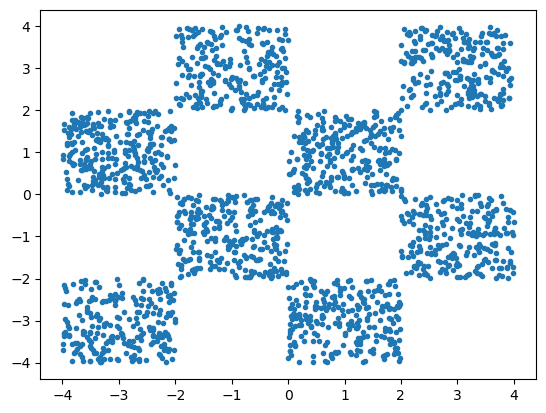

In [2]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x
X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [3]:
Activation = Callable[[jax.Array], jax.Array]


class EnergyModel(nn.Module):
    features: Sequence[int]
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        energy = nn.Dense(1)(x)  # 输出一个能量值
        return energy  # 返回能量

# 创建能量模型实例
model = EnergyModel(features=[64, 64, 64])
print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))



                              EnergyModel Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module      ┃ inputs        ┃ outputs       ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ EnergyModel │ float32[1,2]  │ float32[1,1]  │                      │
├─────────┼─────────────┼───────────────┼───────────────┼──────────────────────┤
│ Dense_0 │ Dense       │ float32[1,2]  │ float32[1,64] │ bias: float32[64]    │
│         │             │               │               │ kernel:              │
│         │             │               │               │ float32[2,64]        │
│         │             │               │               │                      │
│         │             │               │               │ 192 (768 B)          │
├─────────┼─────────────┼───────────────┼───────────────┼──────────────────────┤
│ Dense_1 │ Dense       │ f

In [4]:
def ebm_loss(params: chex.ArrayTree, positive_batch: jax.Array, negative_batch: jax.Array) -> float:
    positive_energy = jnp.mean(model.apply(params, positive_batch))
    negative_energy = jnp.mean(model.apply(params, negative_batch))
    return negative_energy - positive_energy  # 最大化正样本与负样本的能量差


In [5]:
def langevin_dynamics(params, initial_samples, model, step_size, num_steps, noise_scale, key):
    def update(x, key):
        grad_energy = jax.grad(lambda x: jnp.mean(model.apply(params, x)))(x)
        key, subkey = jax.random.split(key)
        noise = jax.random.normal(subkey, x.shape)
        x = x - 0.5 * step_size * grad_energy + noise_scale * jnp.sqrt(step_size) * noise
        return x, key

    key, *subkeys = jax.random.split(key, num_steps + 1)
    subkeys = iter(subkeys)
    for _ in range(num_steps):
        initial_samples, key = update(initial_samples, next(subkeys))

    return initial_samples


In [6]:
class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [7]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))
params = model.init(next(prng_seq), X_train[:1, ...])
opt_state = optimizer.init(params)

@jax.jit
def do_batch_update(params: chex.ArrayTree, opt_state: optax.OptState, pos_batch: jax.Array, neg_batch: jax.Array):
    loss, grad = jax.value_and_grad(ebm_loss)(params, pos_batch, neg_batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

bm = BatchManager(data=X_train, batch_size=128, key=next(prng_seq))
key = jax.random.PRNGKey(0)
step_size = 1e-2 
num_steps = 50
noise_scale = 0.1  # 噪声规模
batch_size = 128  # 负样本的批量大小
dim = X_train.shape[1]
initial_samples = jax.random.normal(key, (batch_size, dim))


losses = []
for _ in tqdm.tqdm(range(5000)):
    pos_batch = next(bm)  # 正样本
    neg_batch = negative_samples = langevin_dynamics(params, initial_samples, model, step_size, num_steps, noise_scale, key)
    loss, params, opt_state = do_batch_update(params, opt_state, pos_batch, neg_batch)
    losses.append(loss)
losses = np.array(losses)


100%|██████████| 5000/5000 [31:28<00:00,  2.65it/s]


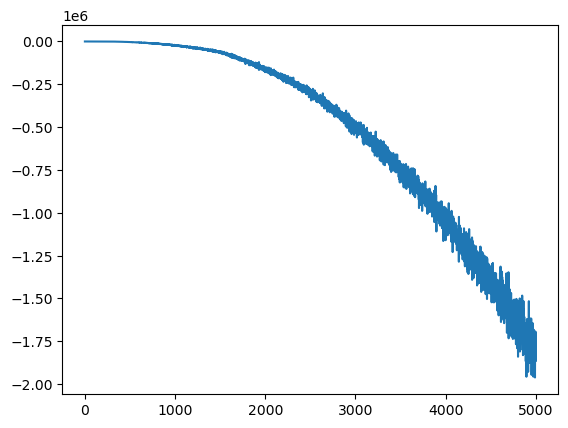

In [8]:
plt.plot(losses)

In [9]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

In [10]:
step_size = 0.005  # 步长
num_steps = 1000  # Langevin 更新的步数
noise_scale = 0.0005  # 噪声规模
key = jax.random.PRNGKey(0)  # 随机键

# 初始化样本，确保其维度和模型输入维度一致
initial_samples = 2 * jax.random.normal(next(prng_seq), shape=(2000, 2))  # 假设 X_train 是二维的

# 生成样本
samples = langevin_dynamics(params, initial_samples, model, step_size, num_steps, noise_scale, key)
print(samples)

[[ 6.361057  -7.6747704]
 [ 6.369606  -7.681794 ]
 [ 6.3964267 -7.7192125]
 ...
 [ 6.381937  -7.695457 ]
 [ 6.376975  -7.713486 ]
 [ 6.362355  -7.698765 ]]


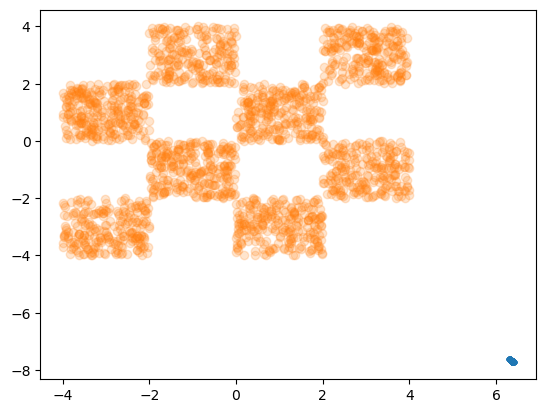

In [11]:
plt.plot(samples[:, 0], samples[:, 1], '.')
plt.plot(X_train[:, 0], X_train[:, 1], 'o', alpha=0.2)

{'params': {'Dense_0': {'bias': Array([4.373376 , 6.2097673, 4.7209563, 7.8826575, 6.648794 , 6.427059 ,
       5.50656  , 6.935238 , 6.0052347, 5.0413713, 7.196801 , 5.7266946,
       4.0726814, 7.8653545, 5.2000895, 6.4031115, 7.815321 , 5.725315 ,
       6.083991 , 6.7676625, 7.7022657, 7.759025 , 4.5028   , 7.802935 ,
       5.0113597, 7.418443 , 7.31918  , 7.757354 , 7.874415 , 5.481863 ,
       6.484022 , 6.534051 , 5.6542115, 5.3552103, 5.8648105, 5.863534 ,
       6.1209607, 5.987744 , 2.4557695, 5.8550816, 7.18512  , 7.897318 ,
       2.0179458, 5.911901 , 7.209449 , 6.3157134, 6.627325 , 5.8067317,
       6.051598 , 3.256006 , 5.48765  , 7.946174 , 4.6947947, 7.2337046,
       6.7116423, 7.878144 , 5.3478036, 5.1737475, 7.8719754, 5.9480195,
       7.8932905, 4.8517632, 7.3083854, 6.85413  ], dtype=float32), 'kernel': Array([[ 7.8712616, -8.10104  ,  7.995527 , -7.3866024,  7.737379 ,
        -8.914379 , -7.590509 , -8.434243 ,  8.506294 ,  8.150882 ,
        -8.369982 , -8.2

ValueError: array of sample points is empty

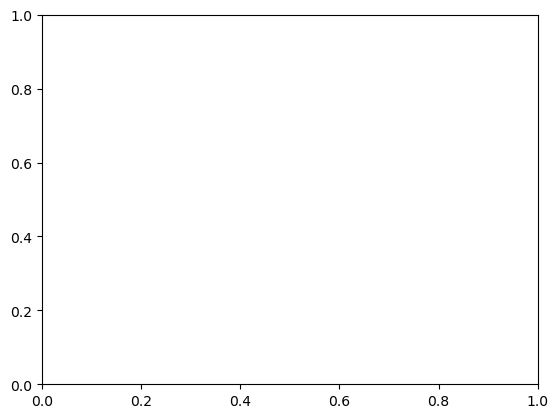

In [12]:
print(params)
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(2000, 2)),
    1000)
print(samples.shape)
print(samples[:,0])
print(X_train.shape)
plt.plot(samples[:, 0], samples[:, 1], '.')
plt.plot(X_train[:, 0], X_train[:, 1], 'o', alpha=0.2)

plt.xlim([-4, 4])
plt.ylim([-4, 4])